In [2]:
%load_ext autoreload
%autoreload 2


# Imports

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import shap
import xgboost as xgb


from matplotlib.colors import LinearSegmentedColormap

from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from src.data_processing.pipelines.ClassifierPipe import ClassifierPipe


# Reproduce processing pipeline 

In [4]:
DATA_PATH = '/projects/p31961/gaby_data/aggregated_data/raw_data/datasets/raw_data_raw_data.parquet.gzip'
SUBJECT_ID_PATH = '/projects/p31961/ENIGMA/results/experiments/xgb_regression_hyperopt/subjects.json'

processor_pipe = (ClassifierPipe(DATA_PATH)
                      .read_raw_data()
                      .calculate_max_min_signal()
                      .calculate_percent_avoid()
                      .drop_features(["event", "action", "trial", "trial_count", "num_avoids", "max_trial"])
                      .split_data(target = "ratio_avoid",
                                load_subject_ids = True, 
                                subject_ids_path = SUBJECT_ID_PATH, 
                                save_subject_ids=False)
                      .transform_data()
)


# Train Regressor using opimtized parameteres

In [5]:
best_params = {'booster': 'gbtree', 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 6, 'min_child_weight': 7, 'n_estimators': 250, 'reg_lambda': 1.0, 'subsample': 0.8}

model = xgb.XGBRegressor(
        objective='reg:squarederror', 
        eval_metric=['rmse', 'mae'],
        **best_params)
model.fit(processor_pipe.X_train, processor_pipe.y_train)

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=['rmse', 'mae'],
             feature_types=None, gamma=0, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=7, missing=nan,
             monotone_constraints=None, n_estimators=250, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None, ...)

## Evalulate on dev set

In [6]:
print(f" MSE for optimzied model on development test is {model.score(processor_pipe.X_dev, processor_pipe.y_dev)}")
print(f" MSE for optimzied model on test is {model.score(processor_pipe.X_test, processor_pipe.y_test)}")
print(f" MSE for optimzied model on train is {model.score(processor_pipe.X_train, processor_pipe.y_train)}")

 MSE for optimzied model on development test is -1.143011063962779
 MSE for optimzied model on test is 0.44434786700729056
 MSE for optimzied model on train is 0.999359336054465


# Predict on test set

In [7]:
predicted_performance = model.predict(processor_pipe.X_test)

# Plotting test set vs inference 


In [8]:
def get_cols_from_pipeline(pipeline):
        num_cols = pipeline.processor.named_transformers_["num"].get_feature_names_out().tolist()
        cat_cols = pipeline.processor.named_transformers_["cat"].get_feature_names_out().tolist()
        return num_cols + cat_cols
def get_df_from_pipeline(pipeline, predicted_values):
        cols = get_cols_from_pipeline(pipeline)
        
        df = (pd.DataFrame(pipeline.X_test, columns=cols)
              .assign(predicted_values = predicted_values, 
                      true_values = pipeline.y_test.values))
        values_cat = ['predicted_values', 'true_values']

        return  (
                df
                .melt(id_vars = [col for col in df.columns if col not in values_cat],
                value_vars = values_cat, 
                var_name = "inference_cat",
                value_name='ratio_avoid')
                .assign(male = lambda df_: df_.sex_M.astype(bool))
                .drop(columns=['sex_M', 'sex_F'])
        )
                
testing_df = get_df_from_pipeline(processor_pipe, predicted_performance)
testing_df

,mouse_id,day,signal_max,signal_min,signal_trapz,pos_signal_trapz,neg_signal_trapz,sensor_D1,sensor_D2,sensor_DA,inference_cat,ratio_avoid,male
0,-0.249856,-1.416555,-0.695553,0.523437,-0.173122,-0.626593,0.319242,1.0,0.0,0.0,predicted_values,0.463536,True
1,-0.249856,-1.416555,1.579697,0.395103,-0.471041,-0.638406,-0.163517,0.0,0.0,1.0,predicted_values,0.464650,True
2,-0.249856,-1.416555,-0.275176,-0.266413,-1.237924,-1.166851,-0.924201,1.0,0.0,0.0,predicted_values,0.464318,True
3,-0.249856,-1.416555,2.912181,0.089504,0.064025,0.220974,-0.107655,0.0,0.0,1.0,predicted_values,0.464669,True
4,-0.249856,-1.416555,0.478908,1.054361,0.778187,0.196755,1.100447,1.0,0.0,0.0,predicted_values,0.462890,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5221,1.587260,1.521512,-1.174288,0.112548,-0.242651,-1.082070,0.644718,0.0,1.0,0.0,true_values,0.928571,False
5222,1.587260,1.521512,0.103718,-0.143197,0.007067,0.237800,-0.218420,0.0,0.0,1.0,true_values,0.928571,False
5223,1.587260,1.521512,-1.348900,0.183924,-0.525469,-1.082329,0.175827,0.0,1.0,0.0,true_values,0.928571,False
5224,1.587260,1.521512,-1.292167,0.186598,-0.245389,-1.072643,0.631053,0.0,1.0,0.0,true_values,0.928571,False


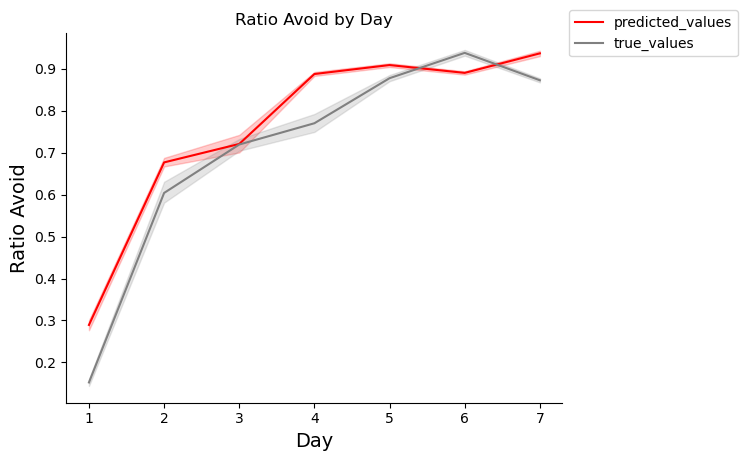

In [9]:
fig, ax = plt.subplots()
sns.lineplot(data=testing_df, x='day', y='ratio_avoid', hue='inference_cat', palette=['red', 'grey'], ax = ax)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 1.0))
plt.xticks(testing_df.day.unique(), np.arange(1,8,1))



ax.set_xlabel('Day', fontsize=14)
ax.set_ylabel('Ratio Avoid', fontsize=14)
ax.set_title('Ratio Avoid by Day')
sns.despine()

---
# Feature Importance


Text(0.5, 1.0, 'Feature Importance')

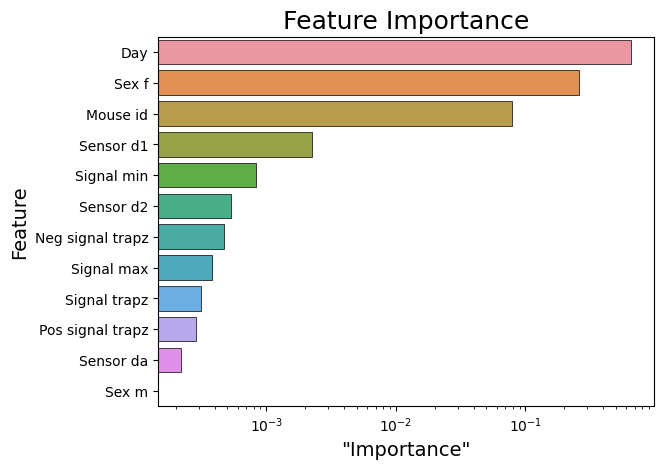

In [10]:
cols = get_cols_from_pipeline(processor_pipe)
feature_importance = (
    pd.Series(
    model.feature_importances_, index = cols)
    .sort_values(ascending=False)
)
feature_importance
col_labels = [col.capitalize().replace('_', ' ') for col in feature_importance.index]
fig, ax = plt.subplots()
sns.barplot(x=feature_importance, y=feature_importance.index, ax=ax, linewidth=0.5, edgecolor='black')
ax.set_yticklabels(col_labels)
ax.set_xscale("log")
ax.set_xlabel('"Importance"', fontsize=14)
ax.set_ylabel('Feature', fontsize=14)
ax.set_title('Feature Importance', fontsize = 18)

## SHAP from feature space

In [11]:
shap_values = shap.TreeExplainer(model).shap_values(processor_pipe.X_test)
shap_interaction_values = shap.TreeExplainer(model).shap_interaction_values(processor_pipe.X_test)

In [12]:
explainer = shap.TreeExplainer(model, processor_pipe.X_train)
shap_values = explainer(processor_pipe.X_train)

# np.abs(shap_values.sum(axis=1) + explanation.base_values - predicted_performance).max()
# 0.0

 99%|===================| 7842/7922 [00:44<00:00]        

In [39]:
import inspect
sig = inspect.signature(shap.summary_plot)
sig.parameters

mappingproxy({'shap_values': <Parameter "shap_values">,
              'features': <Parameter "features=None">,
              'feature_names': <Parameter "feature_names=None">,
              'max_display': <Parameter "max_display=None">,
              'plot_type': <Parameter "plot_type=None">,
              'color': <Parameter "color=None">,
              'axis_color': <Parameter "axis_color='#333333'">,
              'title': <Parameter "title=None">,
              'alpha': <Parameter "alpha=1">,
              'show': <Parameter "show=True">,
              'sort': <Parameter "sort=True">,
              'color_bar': <Parameter "color_bar=True">,
              'plot_size': <Parameter "plot_size='auto'">,
              'layered_violin_max_num_bins': <Parameter "layered_violin_max_num_bins=20">,
              'class_names': <Parameter "class_names=None">,
              'class_inds': <Parameter "class_inds=None">,
              'color_bar_label': <Parameter "color_bar_label='Feature value'"

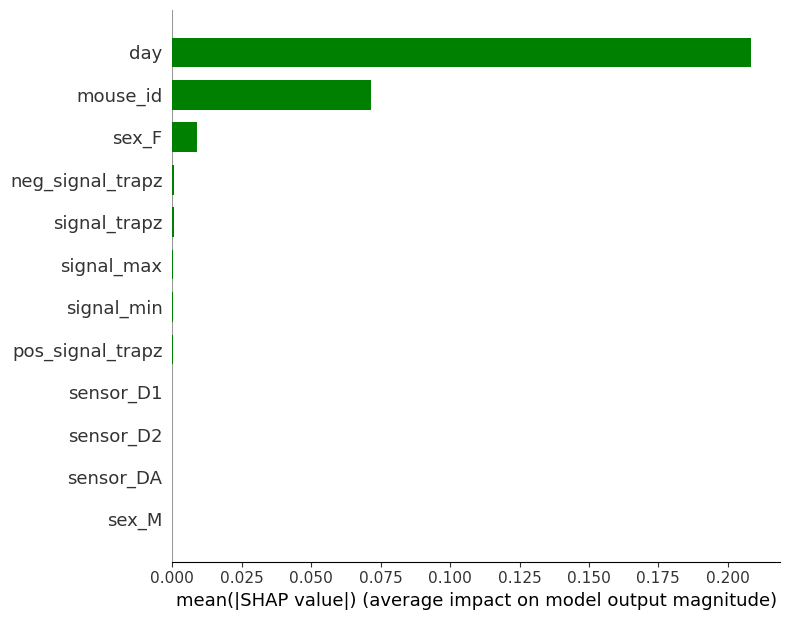

In [53]:
shap.summary_plot(shap_values, 
                  processor_pipe.X_test,
                  plot_type = 'bar',
                  color = 'green',
                  feature_names = cols)
plt

In [105]:
import inspect
# sig = inspect.signature(shap_values)
# sig.parameters
# dir(shap_values)

<BarContainer object of 12 artists>

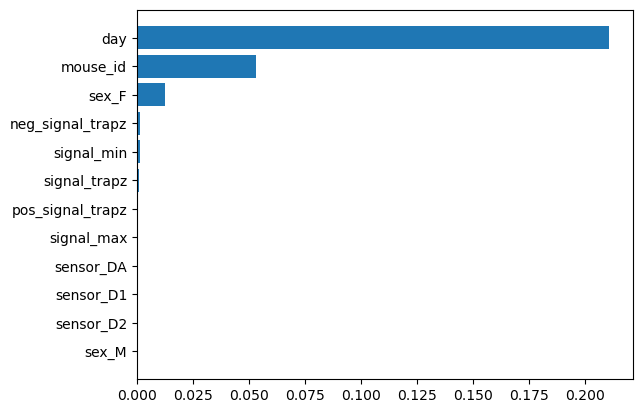

In [104]:
shap_df = pd.DataFrame(
    shap_values.values, columns=cols
)
values = shap_df.mean().abs().sort_values(ascending=True)*10
plt.barh(values.index, values)


## Dimentional Reduction of SHAP

In [ ]:
shap_values[0]

In [ ]:
shap_pca = PCA(n_components=2).fit_transform(shap_values)
sns.scatterplot(x=shap_pca[:,0], y=shap_pca[:,1], c = shap_values.sum(1), cmap="RdBu_r")

my custom init
This is a custom attribute


TypeError: object.__new__(): not enough arguments